##Import Required Libraries

In [17]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


##Load the Dataset

In [18]:
df = pd.read_csv("retail_orders.csv", encoding="latin1")

print(df.shape)
print(df.head())

(2121, 21)
   Row ID        Order ID  Order Date   Ship Date       Ship Mode Customer ID  \
0       1  CA-2016-152156   11/8/2016  11/11/2016    Second Class    CG-12520   
1       2  CA-2016-152156   11/8/2016  11/11/2016    Second Class    CG-12520   
2       4  US-2015-108966  10/11/2015  10/18/2015  Standard Class    SO-20335   
3       6  CA-2014-115812    6/9/2014   6/14/2014  Standard Class    BH-11710   
4      11  CA-2014-115812    6/9/2014   6/14/2014  Standard Class    BH-11710   

     Customer Name   Segment        Country             City  ... Postal Code  \
0      Claire Gute  Consumer  United States        Henderson  ...       42420   
1      Claire Gute  Consumer  United States        Henderson  ...       42420   
2   Sean O'Donnell  Consumer  United States  Fort Lauderdale  ...       33311   
3  Brosina Hoffman  Consumer  United States      Los Angeles  ...       90032   
4  Brosina Hoffman  Consumer  United States      Los Angeles  ...       90032   

   Region      

## Data Preprocessing
### Convert date column to datetime

In [19]:
df['Order Date'] = pd.to_datetime(df['Order Date'])

###Aggregate order-level data to daily sales

In [20]:
daily_sales = (
    df.groupby('Order Date')
      .agg(
          total_sales=('Sales', 'sum'),
          orders_count=('Order ID', 'nunique'),
          avg_order_value=('Sales', 'mean')
      )
      .reset_index()
)

print(daily_sales.head())

  Order Date  total_sales  orders_count  avg_order_value
0 2014-01-06     2573.820             1        2573.8200
1 2014-01-07       76.728             1          76.7280
2 2014-01-10       51.940             1          51.9400
3 2014-01-11        9.940             1           9.9400
4 2014-01-13      879.939             2         439.9695


## Visualize Daily Sales Over Time
A simple line chart of daily total sales helps reveal trends, spikes, and seasonality in the data.

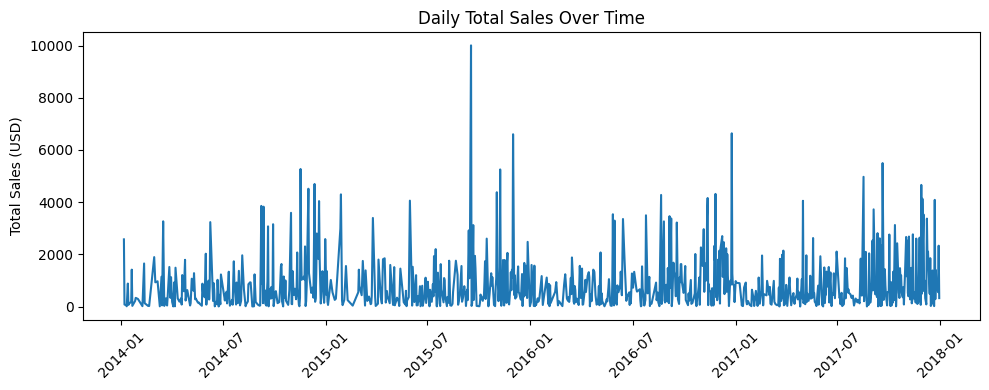

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.plot(daily_sales['Order Date'], daily_sales['total_sales'])
plt.xticks(rotation=45)
plt.ylabel('Total Sales (USD)')
plt.title('Daily Total Sales Over Time')
plt.tight_layout()
plt.show()

## Feature Engineering
### Create calendar-based features

In [22]:
daily_sales['day_of_week'] = daily_sales['Order Date'].dt.dayofweek
daily_sales['is_weekend'] = (daily_sales['day_of_week'] >= 5).astype(int)


### Create lag feature

In [23]:
daily_sales['sales_prev_day'] = daily_sales['total_sales'].shift(1)


### Handle missing values caused by lag

In [24]:
daily_sales = daily_sales.dropna().reset_index(drop=True)


## Define Features and Target

In [25]:
X = daily_sales[
    [
        'day_of_week',
        'is_weekend',
        'orders_count',
        'avg_order_value',
        'sales_prev_day'
    ]
]

y = daily_sales['total_sales']


## Train-Test Split (Time-Based)

In [26]:
split_index = int(len(daily_sales) * 0.8)

X_train = X.iloc[:split_index]
X_test  = X.iloc[split_index:]

y_train = y.iloc[:split_index]
y_test  = y.iloc[split_index:]

## Model Selection & Training
### Linear Regression Mode

In [27]:
model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)


### Evaluation Metrics

In [28]:
# Evaluation metrics for Linear Regression
# MAE  : Average absolute error in daily sales (in USD)
# RMSE : Penalizes larger prediction errors more heavily
# R2   : Proportion of variance in sales explained by the model

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("Linear Regression Results")
print("MAE :", round(mae, 2))
print("RMSE:", round(rmse, 2))
print("R2  :", round(r2, 3))

Linear Regression Results
MAE : 388.67
RMSE: 613.9
R2  : 0.659


### Random Forest Regressor

In [29]:
from sklearn.ensemble import RandomForestRegressor

# Random Forest model
rf_model = RandomForestRegressor(
    n_estimators=200,
    random_state=42
)

rf_model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=200, random_state=42)

### Feature Importance for Random Forest
This chart shows which features contribute most to the Random Forest's sales predictions.

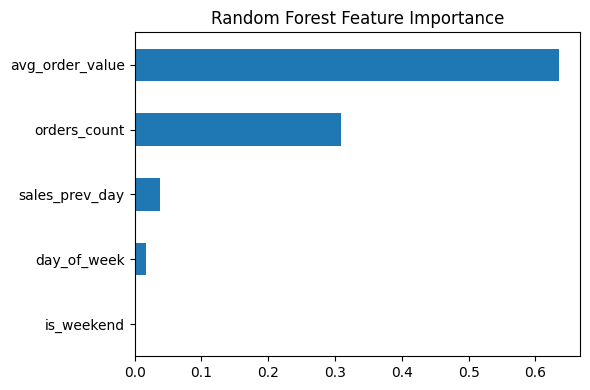

In [30]:
import pandas as pd
import matplotlib.pyplot as plt

rf_importances = pd.Series(rf_model.feature_importances_, index=X.columns)
rf_importances.sort_values().plot(kind='barh', figsize=(6,4))
plt.title('Random Forest Feature Importance')
plt.tight_layout()
plt.show()

### Model Instance for Predictions

In [31]:
y_pred_rf = rf_model.predict(X_test)


###Evaluate the model

In [32]:
# Evaluation metrics for Random Forest
# MAE  : Average absolute error in daily sales (USD)
# RMSE : Penalizes larger errors
# R2   : Variance explained by the model

mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

print("Random Forest Results")
print("MAE :", round(mae_rf, 2))
print("RMSE:", round(rmse_rf, 2))
print("R2  :", round(r2_rf, 3))

Random Forest Results
MAE : 240.69
RMSE: 500.26
R2  : 0.774


## Limitations and Future Work

- The model uses daily aggregated sales and a limited set of calendar and lag features; richer features (product mix, region, discount patterns, holidays) could further improve accuracy.
- The time-based split is realistic, but performance can vary over different time periods; walk-forward validation or multiple train/test windows would give a more robust evaluation.
- Only two models (Linear Regression and Random Forest) are explored; additional algorithms and hyperparameter tuning (e.g., grid search for Random Forest) could be tried on larger datasets.
- In a production setting, the model should be monitored over time and periodically retrained as demand patterns change.